In [1]:
function model = generate_non_gaussian_sequence(lambda, samples)

    % Gaussian white noise
    g1 = randn(samples,1);
    g2 = randn(samples,1);

    % Non-Gaussian multiplicative model
    model = g1 .* exp(lambda * g2 - lambda^2);
end

In [2]:
function cascade = generate_cascade(cascade_steps, samples, lambda)

    if nargin < 1 || cascade_steps == -1
        cascade_steps = floor(log2(samples));   % full cascade
    end
    if nargin < 2
        samples = 2^15;
    end
    if nargin < 3
        lambda = 0.1;
    end


    % Start with Gaussian white noise (lambda = 0)
    cascade = generate_non_gaussian_sequence(0, samples);

    for step = 0:(cascade_steps-1)
        interval_len = floor(samples / 2^step);

        for interval_index = 0:(2^step - 1)

            idx1 = interval_index * interval_len + 1;
            idx2 = (interval_index + 1) * interval_len;

            % Lognormal multiplier
            multiplier = exp(lambda * randn(1) - lambda^2);

            % Apply multiplicative weight
            cascade(idx1:idx2) = cascade(idx1:idx2) * multiplier;
        end
    end
end


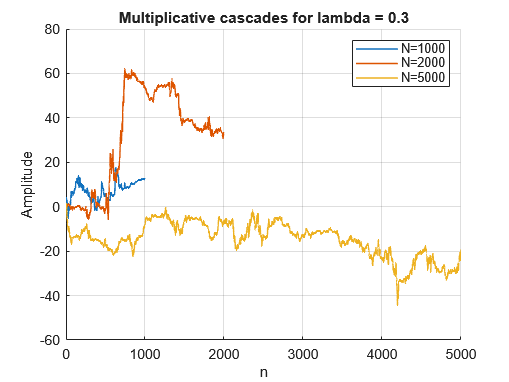


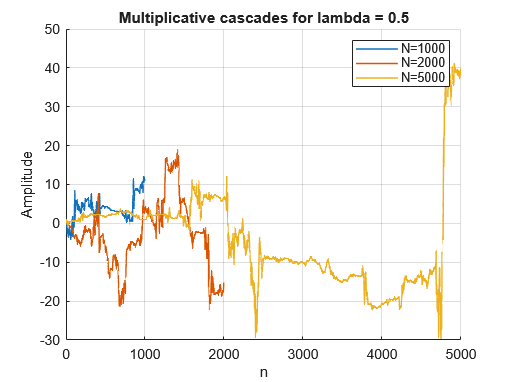

In [3]:
clear; close all; clc;
warning('off','MATLAB:plot:IgnoreImaginaryXYPart')

%% ---------------------------------------------------------
% PARAMETERS
% ---------------------------------------------------------
lambda  = [0.3, 0.5, 0.7];                 % lambda
Nvals  = [1000, 2000, 5000];       % different noise lengths
qvals  = -2:0.1:2;                            % q for tau(q)
numH   = numel(lambda);
numN   = numel(Nvals);

colorsN = lines(numN);                    % colors for different N

%% ---------------------------------------------------------
% STORAGE FOR RESULTS
% cascade{hi,ni}        - signal
% dh{hi,ni}, h{hi,ni} - multifractal spectrum
% cp{hi,ni}         - cumulants [C1 C2 C3]
% tauq{hi,ni}       - scaling function tau(q)
% leaders{hi,ni}    - leaders by scale
% structfunc{hi,ni} - structure function info (Tq, weights, logscales)
% ---------------------------------------------------------
cascade        = cell(numH, numN);
dh         = cell(numH, numN);
h          = cell(numH, numN);
cp         = cell(numH, numN);
tauq       = cell(numH, numN);
leaders    = cell(numH, numN);
structfunc = cell(numH, numN);

%% ---------------------------------------------------------
% MAIN LOOP: GENERATE SIGNALS AND RUN DWTLEADER ONCE
% ---------------------------------------------------------
for hi = 1:numH
    l = lambda(hi);
    for ni = 1:numN
        N = Nvals(ni);

        % Generate cascade
        cascade{hi,ni} = cumsum(generate_cascade(8,N,l));

        % Wavelet leader multifractal analysis
        [h{hi,ni}, tauq{hi,ni}, structfunc{hi,ni}] = wtmm(cascade{hi,ni});

                %% ---------------------------------------------------------
        % NEW: COMPUTE α(q) AND f(α)
        %% ---------------------------------------------------------
        q_axis = linspace(-2, 2, 41);   % same q as WTMM

        tau = tauq{hi,ni};

        % α(q) = dτ/dq
        alpha_q{hi,ni} = gradient(tau, q_axis);

        % f(α) = q α - τ(q)
        f_alpha{hi,ni} = q_axis .* alpha_q{hi,ni} - tau;

    end
end

%% ---------------------------------------------------------
% 1. PLOT cascade SIGNALS (for reference)
% One figure per H, different colors for different N
% ---------------------------------------------------------
for hi = 1:numH
    figure; hold on;
    for ni = 1:numN
        N = Nvals(ni);
        x = 1:N;
        plot(x, cascade{hi,ni}, 'LineWidth', 1.0, 'Color', colorsN(ni,:));
    end
    title("Multiplicative cascades for lambda = " + string(lambda(hi)))
    xlabel("n"); ylabel("Amplitude");
    legend("N="+string(Nvals), ...
        "Location","NorthEast")
    grid on
end

<center>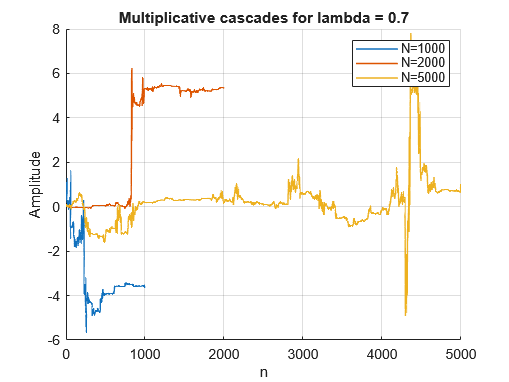</center>




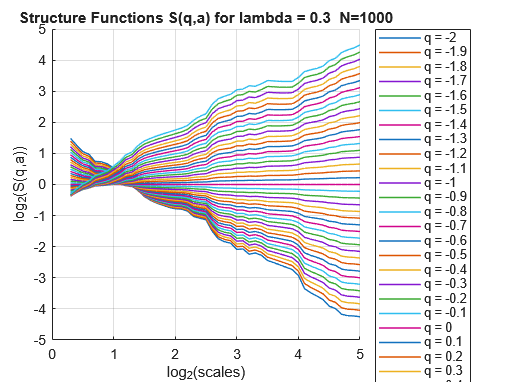


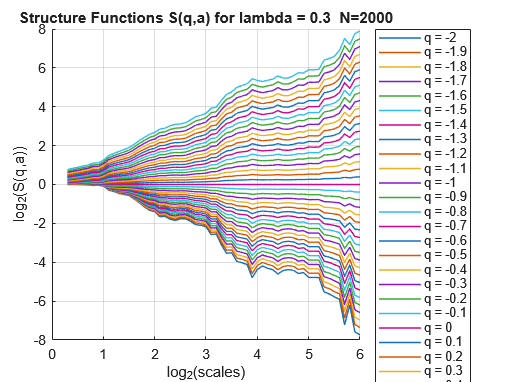

In [4]:

q_axis = -2:0.1:2;   % q values for WTMM structure functions

for hi = 1:numH
    for ni = 1:numN
        S    = structfunc{hi,ni}.Tq(:, 1:41);      % structure functions for q=-5:5
        loga = structfunc{hi,ni}.logscales;        % log2(a)

        figure; hold on;
        plot(loga, S, 'LineWidth', 1.0)


        % Legend labels: "a = scale_value"
        legendStrings = "q = " + string(round(q_axis, 3));
        legend(legendStrings, "Location", "bestoutside")

        xlabel("log_2(scales)")
        ylabel("log_2(S(q,a))")
        title("Structure Functions S(q,a) for lambda = " + string(lambda(hi))+ ...
              "  N="+string(Nvals(ni)))
        grid on
    end
end

<center>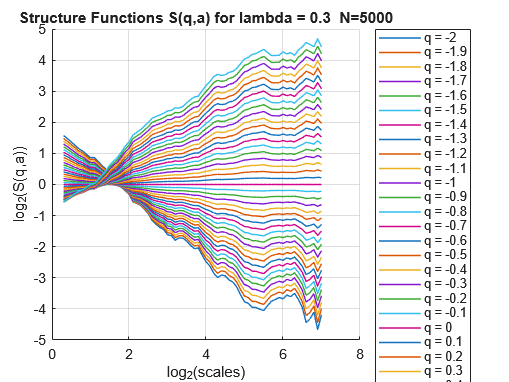</center>


<center>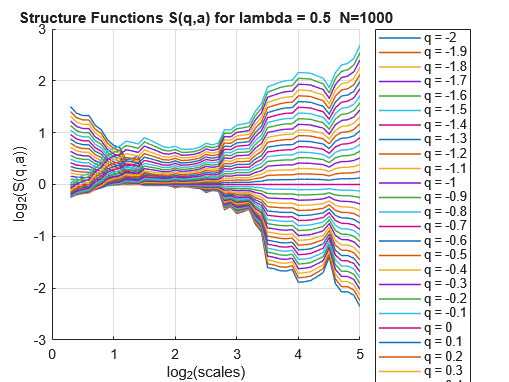</center>


<center>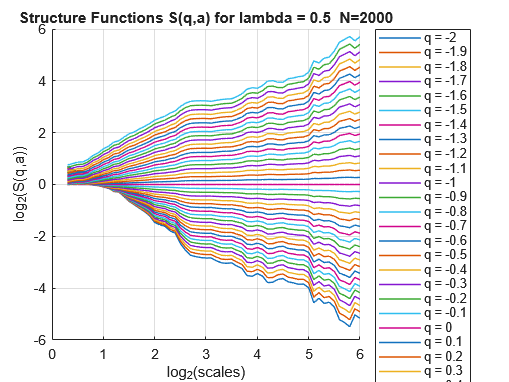</center>


<center>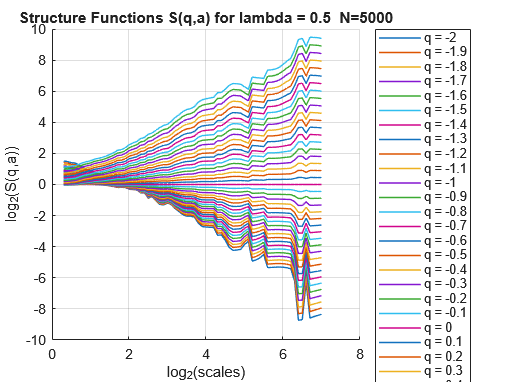</center>


<center>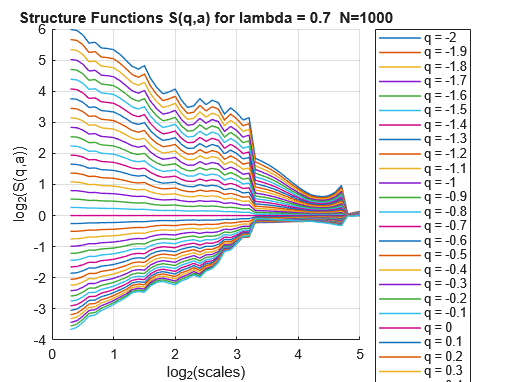</center>


<center>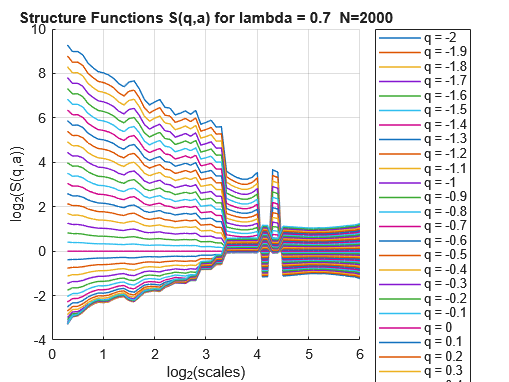</center>


<center>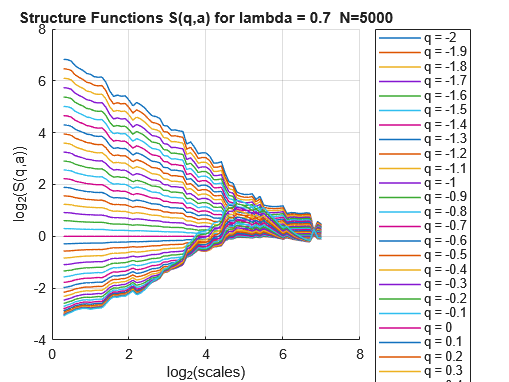</center>




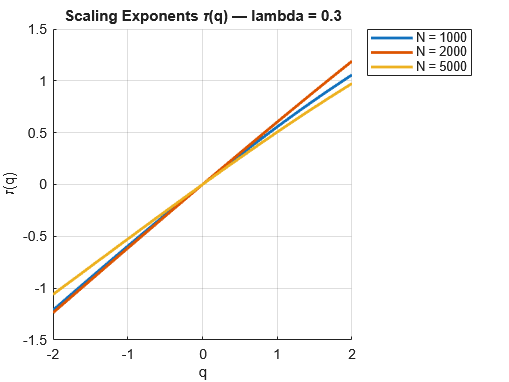


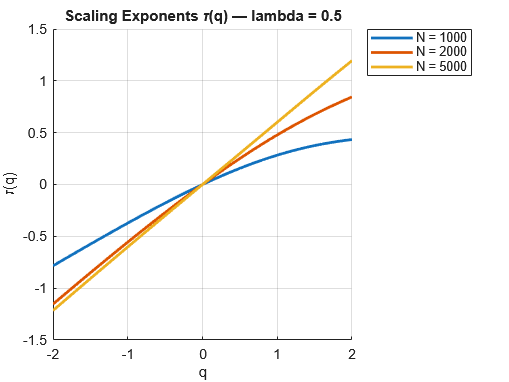

In [5]:

%% ---------------------------------------------------------
% 6. PLOT τ(q) FOR ALL Nvals (separate figure)
% ---------------------------------------------------------
q_axis = linspace(-2, 2, 41);

for hi = 1:numH
    figure; hold on;

    for ni = 1:numN
        tau = tauq{hi,ni};

        plot(q_axis, tau, 'LineWidth', 2, ...
            'Color', colorsN(ni,:), ...
            'DisplayName', "N = " + string(Nvals(ni)));
    end

    xlabel("q");
    ylabel("\tau(q)");
    title("Scaling Exponents \tau(q) — lambda = " + string(lambda(hi)));
    legend("Location","bestoutside");
    grid on;
end

<center>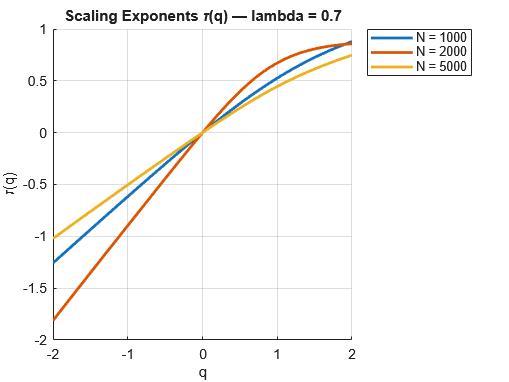</center>




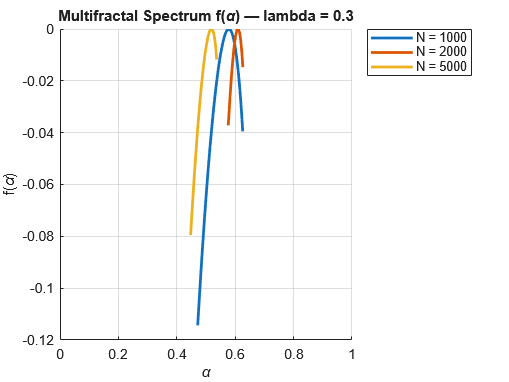


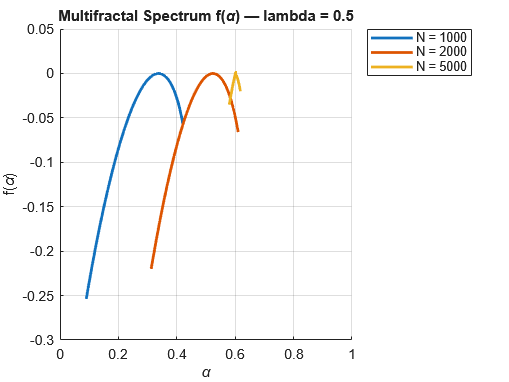

In [6]:

%% ---------------------------------------------------------
% 7. PLOT f(α) FOR ALL Nvals (separate figure)
% ---------------------------------------------------------
for hi = 1:numH
    figure; hold on;

    for ni = 1:numN
        a_q = alpha_q{hi,ni};
        f_a = f_alpha{hi,ni};

        plot(a_q, f_a, 'LineWidth', 2, ...
            'Color', colorsN(ni,:), ...
            'DisplayName', "N = " + string(Nvals(ni)));
    end

    xlabel("\alpha");
    ylabel("f(\alpha)");
    title("Multifractal Spectrum f(\alpha) — lambda = " + string(lambda(hi)) ...
        );
    legend("Location","bestoutside");
    xlim([0 1])

    grid on;
end

<center>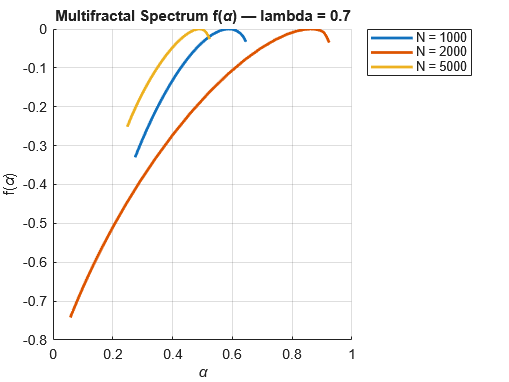</center>



